# Ideas

Can average the results from a DLRM and the node2vec-esque distance model

take out some edges (label them as 1) and insert some edges (label them as 0)
these are what we train on

Node embedding - distance model
1. randomly initialize embeddings for all nodes
2. for each pair of nodes, if they are connected then push their embeddings closer by some amount, otherwise push them farther
3. Do a PCA and visualize the embedding space? or just predict and see what our accuracy is


In [1]:
import csv
import numpy as np
import pandas as pd
from collections import defaultdict
from stellargraph.data import BiasedRandomWalk
from stellargraph import StellarGraph
from gensim.models import Word2Vec
import multiprocessing
import matplotlib.pyplot as plt


2022-01-29 09:32:16.279596: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-01-29 09:32:17.279826: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-01-29 09:32:17.280741: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-01-29 09:32:17.365558: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:1a:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-01-29 09:32:17.367174: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:1b:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-

In [2]:
file = open('bill_challenge_datasets/Training/training_graph.csv')
csvreader = csv.reader(file)
edges = []
for row in csvreader:
    if row[0][0] != "n":
        edges.append(row)

In [3]:
training_edges = []
test_true_edges = []
test_false_edges = []
graph = defaultdict(set)
training_graph = defaultdict(set)
for i, row in enumerate(edges):
    if i % 10 == 0:
        test_true_edges.append(row)
    else:
        training_edges.append(row)
        training_graph[row[0]].add(row[1])
        training_graph[row[1]].add(row[0])
    graph[row[0]].add(row[1])
    graph[row[1]].add(row[0])

for i in range(0, len(edges) - 65000, 2):
    if i % 2 == 0:
        if edges[i][0] not in edges[i + 1] and edges[i][0] not in graph[edges[i + 1][0]]:
            test_false_edges.append([edges[i][0], edges[i+1][0]])


In [ ]:
def jaccard(node1, node2):
    inter = len(training_graph[node1].intersection(training_graph[node2]))
    un = len(training_graph[node1].union(training_graph[node2]))
    return inter / un

for threshold_sim in [1, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75]:
    amount_correct = 0
    amount_incorrect = 0
    for row in test_true_edges:
        try:
            # if distance less than threshold, we predict an edge
            if np.linalg.norm(model.wv[row[0]] - model.wv[row[1]]) < threshold_sim:
                amount_correct += 1
            else:
                amount_incorrect += 1
        except:
            continue
        
    for row in test_false_edges:
        try:
            # if distance less than threshold, we predict an edge
            if np.linalg.norm(model.wv[row[0]] - model.wv[row[1]]) < threshold_sim:
                amount_incorrect += 1
            else:
                amount_correct += 1
        except:
            continue

In [10]:
# naive approach

# embeddings = {}
# for node in graph:
#     embeddings[node] = np.random.rand(2) * 10
# embeddings[node]
# alpha = 1
# for row in edges:
#     mid = embeddings[row[0]] - embeddings[row[1]]
#     embeddings[row[0]] -= alpha * mid
#     embeddings[row[1]] += alpha * mid

In [20]:
# node2vec embedding approach

pdgraph = pd.DataFrame(
    {"source": [x[0] for x in training_edges], "target": [x[1] for x in training_edges]}
)
sgraph = StellarGraph(edges=pdgraph)
print(sgraph.info())

rw = BiasedRandomWalk(sgraph)

walks = rw.run(
    nodes=list(sgraph.nodes()),  # root nodes
    length=100,  # maximum length of a random walk
    n=10,  # number of random walks per root node
    p=1.0,  # Defines (unormalised) probability, 1/p, of returning to source node
    q=1.0,  # Defines (unormalised) probability, 1/q, for moving away from source node
)
print("Number of random walks: {}".format(len(walks)))

StellarGraph: Undirected multigraph
 Nodes: 20539, Edges: 118834

 Node types:
  default: [20539]
    Features: none
    Edge types: default-default->default

 Edge types:
    default-default->default: [118834]
        Weights: all 1 (default)
        Features: none
Number of random walks: 205390


In [69]:
str_walks = [[str(n) for n in walk] for walk in walks]
model = Word2Vec(str_walks, size=20, window=5, min_count=0, sg=1, workers=multiprocessing.cpu_count(), epochs=3)
model.wv["14416"].shape

(20,)

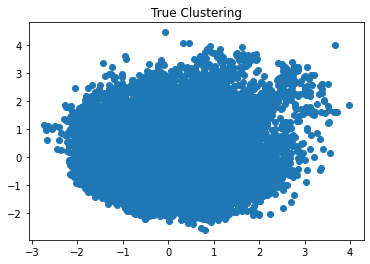

In [67]:
from sklearn.decomposition import PCA
X = [model.wv[x] for x in training_graph.keys()]
pca = PCA(n_components=2)
pca.fit(X)
newX = pca.transform(X)
plt.scatter([x[0] for x in newX], [x[1] for x in newX])
plt.title("True Clustering")
plt.show()

In [72]:
for threshold_dist in [1, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75]:
    amount_correct = 0
    amount_incorrect = 0
    for row in test_true_edges:
        try:
            # if distance less than threshold, we predict an edge
            if np.linalg.norm(model.wv[row[0]] - model.wv[row[1]]) < threshold_dist:
                amount_correct += 1
            else:
                amount_incorrect += 1
        except:
            continue
        
    for row in test_false_edges:
        try:
            # if distance less than threshold, we predict an edge
            if np.linalg.norm(model.wv[row[0]] - model.wv[row[1]]) < threshold_dist:
                amount_incorrect += 1
            else:
                amount_correct += 1
        except:
            continue

    print(f"ThresholdDist: {threshold_dist} Accuracy: {amount_correct / (amount_correct + amount_incorrect)}")

ThresholdDist: 1 Accuracy: 0.5230586249232658
ThresholdDist: 1.25 Accuracy: 0.5466543891958257
ThresholdDist: 1.5 Accuracy: 0.5713627992633518
ThresholdDist: 1.75 Accuracy: 0.5926181706568447
ThresholdDist: 2 Accuracy: 0.6064686924493554
ThresholdDist: 2.25 Accuracy: 0.6108041743400859
ThresholdDist: 2.5 Accuracy: 0.600560159607121
ThresholdDist: 2.75 Accuracy: 0.5822206875383671


In [69]:
len(test_true_edges)

13204

In [22]:
import json
 
f = open('bill_challenge_datasets/Training/node_features_text.json')
data = json.load(f)
freq_words = defaultdict(int)
for node, vector in data.items():
    for word in vector:
        freq_words[word] += 1

significant_words = {x[0] for x in freq_words.items() if x[1] > 100 and x[1] < 2000}
print(f"There are {len(significant_words)} sig words")
old_to_new = {}
idx = 0
for word in significant_words:
    old_to_new[word] = idx
    idx += 1
good_one_hot_vectors = {}
for node, vector in data.items():
    good_one_hot_vectors[node] = [0 for _ in range(len(significant_words))]
    for word in vector:
        if word in significant_words:
            good_one_hot_vectors[node][int(old_to_new[word])] = 1

There are 407 sig words


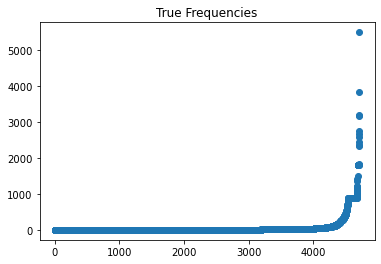

In [23]:
plt.scatter([x for x in range(len(freq_words.keys()))], [x for x in sorted(freq_words.values())])
plt.title("True Frequencies")
plt.show()

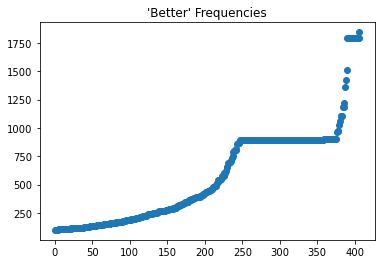

In [24]:
sig_freqs = [x[1] for x in freq_words.items() if x[1] > 100 and x[1] < 2000]
plt.scatter([x for x in range(len(sig_freqs))], [x for x in sorted(sig_freqs)])
plt.title("'Better' Frequencies")
plt.show()